## Use the ProcessWordle Module

In [ ]:
import ProcessWordle as ScrabblePoints, ParseWordle
import censoring

In [ ]:
sp = ScrabblePoints(censoring.wordle_answers_input)
sp.read_wordle_answers()
sp.add_total_and_difficulty()

pw = ParseWordle(
    censoring.raw_whatsapp_input, 
    censoring.wordle_output,
    censoring.name_alias
)
pw.create_wordle_df()
pw.process_data_frame()
pw.join_data_frame(sp.words_df)
pw.write_final_df()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import censoring
from scipy.special import logit, expit

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [2]:
# load data
df = pd.read_csv(censoring.wordle_output)

In [3]:
# limit to the puzzle in which we last have words (396)
df2 = df[ (df['PuzzleNum'] < 447) & (df['PuzzleNum'] != 421) & (df['Difficulty'] != 'Undefined')].copy()

In [4]:
df2.head()

,Date_Time,Name,Game,PuzzleNum,FinalScore,Fails,Answer,ScrabblePoints,Difficulty
0,2021-12-31 10:46:00,Player1,Wordle,195,6,5,unify,11.0,Medium
1,2021-12-31 10:47:00,Player2,Wordle,195,6,5,unify,11.0,Medium
2,2021-12-31 11:02:00,Player3,Wordle,195,3,2,unify,11.0,Medium
3,2021-12-31 13:46:00,Player4,Wordle,195,5,4,unify,11.0,Medium
4,2022-01-01 11:58:00,Player3,Wordle,196,5,4,rebus,7.0,Easy


In [5]:
name_factor, player_names = pd.factorize(df2['Name'], sort=True)
diff_factor, diff_categ = pd.factorize(df2['Difficulty'], sort=True)

In [6]:
coords = {
    "obs": df2.index.values,  
    "player_names": player_names,
    "diff_categ": diff_categ
}

## Model 0

In [7]:
with pm.Model(coords=coords) as BB0:
    # hyperpriors - Names
    NamesHα = pm.Gamma("NamesHαHα", alpha=3, beta=3) 
    NamesHβ = pm.Gamma("NamesHβ", alpha=3, beta=3) 
    
    # hyperpriors - Difficulty
    DiffHα = pm.Gamma("DiffHα", alpha=3, beta=3) 
    DiffHβ = pm.Gamma("DiffHβ", alpha=3, beta=3) 
    
    # prior - Names
    NamesΘα = pm.Poisson("NamesΘα", mu=NamesHα, dims="player_names")
    NamesΘβ = pm.Poisson("NamesΘβ", mu=NamesHβ, dims="player_names")
    
    # prior - Difficulty
    DiffΘα = pm.Poisson("DiffΘα", mu=DiffHα, dims="diff_categ")
    DiffΘβ = pm.Poisson("DiffΘβ", mu=DiffHβ, dims="diff_categ")
    
    # likelihood
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=NamesΘα[name_factor] + DiffΘα[diff_factor], 
        beta=NamesΘβ[name_factor] + DiffΘβ[diff_factor], 
        observed=df2["Fails"].values
    )

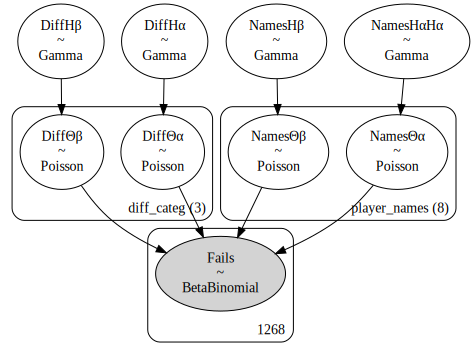

In [8]:
pm.model_to_graphviz(BB0)

In [9]:
with BB0:
    trace0 = pm.sample(
        1000,
        tune=2000,
        return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [NamesHαHα, NamesHβ, DiffHα, DiffHβ]
>CompoundStep
>>Metropolis: [NamesΘα]
>>Metropolis: [NamesΘβ]
>>Metropolis: [DiffΘα]
>>Metropolis: [DiffΘβ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 175 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5197, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.599, but should be close to 0.8. Try to increase the number of tuning steps.


# Plot Coefficients

In [10]:
az.waic(trace0)

Computed from 4000 posterior samples and 1268 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1930.90    14.86
p_waic        6.29        -

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

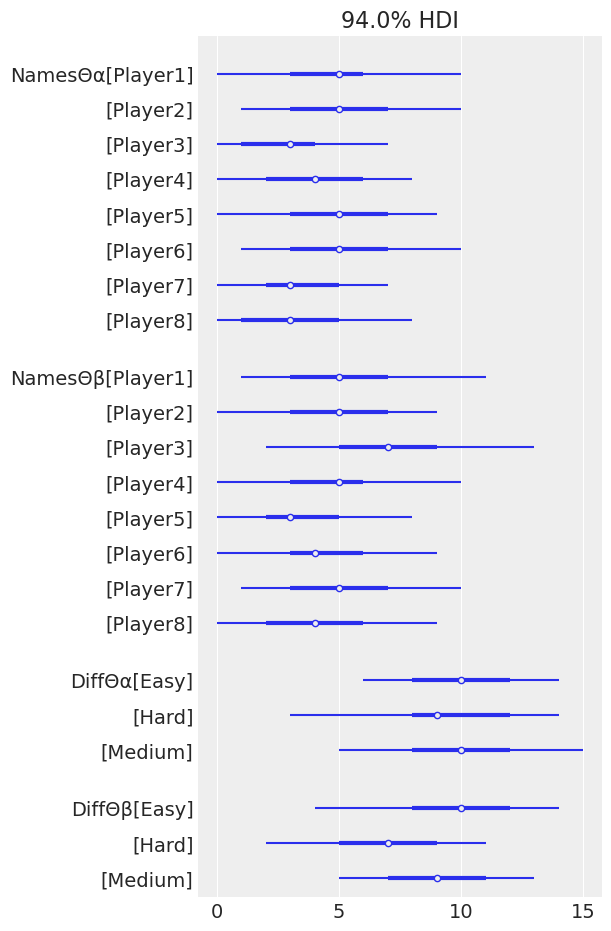

In [11]:
az.plot_forest(trace0, var_names=['NamesΘα', 'NamesΘβ', 'DiffΘα', 'DiffΘβ'], combined=True)

In [12]:
az.summary(trace0, var_names=['NamesΘα', 'NamesΘβ', 'DiffΘα', 'DiffΘβ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
NamesΘα[Player1],4.792,2.707,0.0,10.0,0.770,0.558,12.0,57.0,1.26
NamesΘα[Player2],5.112,2.684,1.0,10.0,0.686,0.495,16.0,120.0,1.18
NamesΘα[Player3],2.999,2.121,0.0,7.0,0.441,0.316,24.0,122.0,1.13
NamesΘα[Player4],4.126,2.417,0.0,8.0,0.517,0.371,21.0,49.0,1.14
NamesΘα[Player5],4.968,2.726,0.0,9.0,0.550,0.394,25.0,113.0,1.12
NamesΘα[Player6],4.949,2.678,1.0,10.0,0.723,0.523,14.0,103.0,1.20
NamesΘα[Player7],3.318,2.279,0.0,7.0,0.466,0.334,25.0,296.0,1.11
NamesΘα[Player8],3.499,2.762,0.0,8.0,0.458,0.327,36.0,171.0,1.08
NamesΘβ[Player1],5.350,2.917,1.0,11.0,0.861,0.625,12.0,75.0,1.25
NamesΘβ[Player2],5.144,2.636,0.0,9.0,0.796,0.579,12.0,42.0,1.27


# Compare

In [13]:
# az.plot_forest([trace0, trace1], var_names=['Θα', 'Θβ'], combined=True)
# az.compare({'BB': trace0, 'BB2': trace1}, 'waic')